# Rule-based control of the solar home (Python)

This is the simplest control scheme of the solar home, implemented in Python. It can be used as an example of how to use the solar home test bench in this language. Rule-based control yields a good baseline performance for comparing more advanced energy management methods.

See also:
* [Python_rule-based-optim.ipynb](Python_rule-based-optim.ipynb): a slightly more complex rule-based control, with one parameter to be optimized using training data
* [Julia_rule-based.ipynb](../julia_rule-based/Julia_rule-based.ipynb): an equivalent example in Julia

Pierre Haessig, July 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!! ls examples

['load_and_generation.pkl']

In [5]:
imported = pd.read_pickle('examples/load_and_generation.pkl')
imported.sample()

,17.64_1kWp_generation_kWh,load_kWh,import_kWh,export_kWh
2019-05-02 05:00:00,11.199535,10.176987,0.0,-1.022548


In [6]:
P_sun, P_load = imported.iloc[:,0], imported.iloc[:,1]

In [7]:
P_sun.name.split('_')[0]

'17.64'

Import solarhome utility module `benchutils`, using `bu` as a short alias.

## 2. Rule based control

control rules:

* storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
* if empty, use grid instead
* if full, curtail the excess of production

inputs: $P_{sun}$, $P_{load}$ and storage state $E_{sto}$

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

def: net load: $P_{nl} = P_{load} - P_{sun}$

* if $P_{nl}>0$ (load > sun)
  * if battery not empty: battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production: $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

In [8]:
def control(P_sun, P_load, E_sto, dt, E_rated):
    """""
    P_sun: Generated power from PV (kW)
    P_load: Building load demand (kW)
    E_sto: Energy stored in the battery (kWh)
    dt: Derivate of time step (Hours)
    
    """""
    P_nl = P_load - P_sun # Net load -> Power needed by building from grid or battery (or combination)
    # outputs:
    P_sto = 0. # The power flowing into the battery (kW)
    P_grid = 0. # The power imported from the grid (kW)
    P_curt = 0. # The power exported to the grid (kW)
    
    E_next = E_sto - P_nl*dt # Energy stored in the battery at the end of current timestep (kWh)
    
    if P_nl>0: # (load > sun) -> Try to discharge the battery to the building load, if energy is available
        #TODO: Limit rate of discharge of battery
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0 # Calculate power flowing out of the battery
        P_grid = P_nl + P_sto # Calculate power taken from the grid as load power minus the batter discharge power
    else: # (load <= sun) -> Try to charge the battery
        E_next = E_next if E_next<E_rated else E_rated # Calculate battery charge state. Don't charge if full.
        P_sto = (E_next - E_sto)/dt # >0 # Calculate power flowing into the battery
        P_curt = -P_nl - P_sto#Calculate exported power: difference between net load and power flowing into battery
    return P_sto, P_grid, P_curt

#solve for one timestep
control(P_sun[0], P_load[0], E_sto=0.0, dt=1, E_rated=8.0)

## 3. Solar home simulation

In [9]:
rv = {}
dt = 1
for i in range(1,50,1):
    E_rated=i
    n = len(P_load)
    P_sto = np.zeros(n)
    E_sto = np.zeros(n+1)
    P_grid = np.zeros(n)
    P_curt = np.zeros(n)

    E_sto[0]= 0 # start the battery at 0% charge

    for k in range(n):
        P_sto[k], P_grid[k], P_curt[k] = control(P_sun.values[k], P_load.values[k], E_sto[k], dt=dt, E_rated=E_rated)
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        assert 0 <= E_sto[k+1] <= E_rated # Check that battery charge is non-negative and not over capacity


    E_sto = E_sto[:-1]
    P_pv = P_sun - P_curt
    P_nl = P_load - P_sun

    results = pd.DataFrame([P_sto, E_sto, P_grid, P_curt]).T.rename(columns={
        0:'P_sto',
        1:'E_sto',
        2:'P_grid',
        3:'P_curt'
    })


    # Power taken from the grid for 
    grid_power = results['P_grid'].sum()
#     print(f'battery size: {i} kWh, energy taken from grid: {grid_power} kWh')
    print('.', end='', flush=True)
    rv[str(i)] = grid_power
# rv

.................................................

Text(0, 0.5, 'Imported Energy (kWh)')

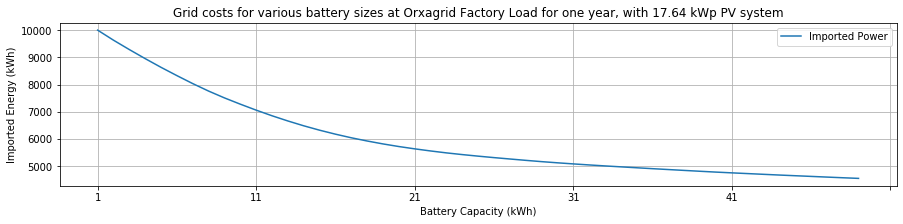

In [10]:
ax = pd.DataFrame(rv.values(), columns=['Imported Power'], index=rv.keys()).plot(
    title='Grid costs for various battery sizes at Orxagrid Factory Load for one year, with 17.64 kWp PV system',
    grid=True, figsize=(15,3))
ax.set_xlabel('Battery Capacity (kWh)')
ax.set_ylabel('Imported Energy (kWh)')

## Method
#### ~~Select type of battery~~
#### ~~Get lifespan of battery~~
#### ~~Get install cost of battery~~
#### ~~Calculate amortized cost of battery per kWh per year~~
#### ~~Get cost of energy per kWh~~
#### ~~Choose initial and step size for battery (e.g. 1 kW with a step size of 0.5 kW)~~
#### For each step size, calculate cost of battery plus cost of import
#### Choose step size at which to stop optimisation
#### Select step size with lowest total cost
### Stretch target: Include export revenue

https://www.greenmatch.co.uk/blog/2018/07/solar-battery-storage-system-cost

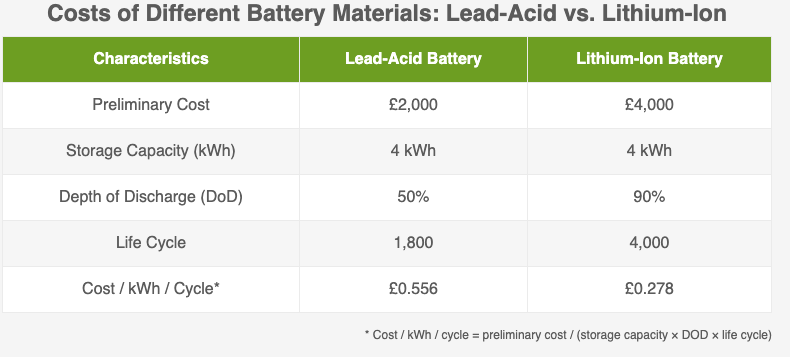

In [13]:
BATTERY_TYPE = 'lithium ion'
DEPTH_OF_DISCHARGE = 0.9
LIFE_CYCLE = 4000
BATTERY_COST_KWH = 1000

In [17]:
IMPORT_COST_KWH = 0.14

In [14]:
discharge_cycles_per_day = 1
days_per_year = 365
cycles_per_year = discharge_cycles_per_day * days_per_year

In [15]:
battery_life_years = LIFE_CYCLE / cycles_per_year
battery_life_years

10.95890410958904

In [16]:
amortized_battery_cost_kwh = BATTERY_COST_KWH / battery_life_years
amortized_battery_cost_kwh

91.25

In [18]:
#Choose initial and step size for battery (e.g. 1 kW with a step size of 0.5 kW)
INITIAL_SIZE = 0
FIXED_STEP_SIZE = 1

In [25]:
# P_sun: Generated power from PV (kW)
# P_load: Building load demand (kW)
# E_sto: Energy stored in the battery (kWh)
# dt: Derivate of time step (Hours)

In [87]:
rv = {}
dt = 1
one_year = len(P_load)
for size in range(0, 10 ,1):
    battery_cost = size * amortized_battery_cost_kwh
    
    E_rated=size
    P_sto = np.zeros(one_year)
    E_sto = np.zeros(one_year+1)
    P_grid = np.zeros(one_year)
    P_curt = np.zeros(one_year)
    E_sto[0]= 0 # start the battery at 0% charge

    for hour in range(one_year):
        P_sto[hour], P_grid[hour], P_curt[hour] = control(P_sun.values[hour], P_load.values[hour], E_sto[hour], dt=dt, E_rated=E_rated)
        E_sto[hour+1] = E_sto[hour] + P_sto[hour]*dt
        assert 0 <= E_sto[hour+1] <= E_rated # Check that battery charge is non-negative and not over capacity
    E_sto = E_sto[:-1]
    P_pv = P_sun - P_curt
    P_nl = P_load - P_sun

    grid_power = P_grid.sum()
    import_cost = grid_power * IMPORT_COST_KWH
    total_cost = battery_cost + import_cost

    rv[size] = grid_power
    print(
        f'Size:{str(size).zfill(2)} \tbattery cost:{battery_cost:.2f} ' + 
        f'\tImport kWh:{grid_power:.2f} \tImport cost:{import_cost:.2f}' +
        f'\tTotal Cost:{total_cost:.2f}')
# rv

Size:00 	battery cost:0.00 	Import kWh:10399.32 	Import cost:1455.90	Total Cost:1455.90
Size:01 	battery cost:91.25 	Import kWh:10006.88 	Import cost:1400.96	Total Cost:1492.21
Size:02 	battery cost:182.50 	Import kWh:9636.80 	Import cost:1349.15	Total Cost:1531.65
Size:03 	battery cost:273.75 	Import kWh:9291.20 	Import cost:1300.77	Total Cost:1574.52
Size:04 	battery cost:365.00 	Import kWh:8958.09 	Import cost:1254.13	Total Cost:1619.13
Size:05 	battery cost:456.25 	Import kWh:8636.93 	Import cost:1209.17	Total Cost:1665.42
Size:06 	battery cost:547.50 	Import kWh:8332.18 	Import cost:1166.51	Total Cost:1714.01
Size:07 	battery cost:638.75 	Import kWh:8037.99 	Import cost:1125.32	Total Cost:1764.07
Size:08 	battery cost:730.00 	Import kWh:7763.00 	Import cost:1086.82	Total Cost:1816.82
Size:09 	battery cost:821.25 	Import kWh:7511.60 	Import cost:1051.62	Total Cost:1872.87


In [47]:
rv

{0: 10399.318787140248,
 1: 10006.879722900476,
 2: 9636.802579650162,
 3: 9291.1951562069,
 4: 8958.093711606356,
 5: 8636.929362479692,
 6: 8332.18036037775,
 7: 8037.9878224132635,
 8: 7763.000239151154,
 9: 7511.601161628768,
 10: 7280.720027830204}

STOP = False
while not STOP:
    